In [1]:
#importing libraries for testing purposes

#Using code from https://developer.nvidia.com/blog/accelerating-inference-up-to-6x-faster-in-pytorch-with-torch-tensorrt/

! pip install timm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 431 kB 39.2 MB/s eta 0:00:01


In [2]:
import torch
import torch_tensorrt
import timm
import time
import numpy as np
import torch.backends.cudnn as cudnn

torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

In [15]:
import cv2
import os
import sys

In [21]:
IMGDIR = "/workspace/w251_Final_Project/Images_test/"
MOLDIR = "/workspace/w251_Final_Project/Model_Efficient_Det/"

In [17]:
def list_files(path):
    # The list of items
    files = os.listdir(path)

    # List of only files
    #files = [f for f in os.listdir(path) if os.path.isfile(f)]
 
    # Loop to print each filename separately
    for filename in files:
        print(filename)

In [18]:
files = os.listdir(MOLDIR)
print(len(files))

1


In [19]:
if "projects" not in os.getcwd():
  !git clone --depth 1 https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
  os.chdir('Yet-Another-EfficientDet-Pytorch')
  sys.path.append('.')
else:
  !git pull

Cloning into 'Yet-Another-EfficientDet-Pytorch'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 3), reused 24 (delta 1), pack-reused 0
Unpacking objects: 100% (47/47), 5.66 MiB | 19.40 MiB/s, done.


In [20]:
!pwd

/workspace/w251_Final_Project/Converting_Model/Yet-Another-EfficientDet-Pytorch/Yet-Another-EfficientDet-Pytorch


In [22]:
labels1 = [chr(i) for i in range(ord('A'),ord('Z')+1)]
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
print(len(labels))
print(len(labels1))

26
26


In [26]:
#!pip install webcolors

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Visualize

/tmp/ipykernel_453/2336784164.py:74: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)


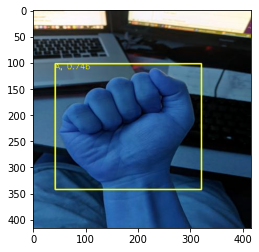

In [27]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

compound_coef = 0
force_input_size = None  # set None to use default size
#img_path = 'datasets/logo/val/208.jpg'
img_path = IMGDIR+"A3_jpg.rf.8850b77ae61284df2b0b40d1475b97f1.jpg"

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

#obj_list = [ 'car', 'light' ]

obj_list = labels

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(1.0, 1.0), (1.3, 0.8), (1.9, 0.5)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load(MOLDIR+"efficientdet-d0_29_5600.pth"))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])



In [29]:
#print(model)

### References:
>- https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [10]:
#traced_mod_trt = torch.jit.trace(trt_model, torch.randn((1,3,224,224)).to("cuda"))
#model_effi_det_ASL = torch.load(MOLDIR+"efficientdet-d0_29_5600.pth")

### Converting to Rt

In [31]:
# model = model_effi_det_ASL.eval().to("cuda")
# detections_batch = model(torch.randn(128, 3, 224, 224).to("cuda"))
# detections_batch.shape

In [32]:
trt_model = torch_tensorrt.compile(model, 
    inputs= [torch_tensorrt.Input((1, 3, 224, 224),dtype=torch.half)],
    enabled_precisions= {torch.float, torch.half} # Run with FP16
)

RuntimeError: 
Module 'SeparableConvBlock' has no attribute 'swish' :
  File "/workspace/w251_Final_Project/Converting_Model/Yet-Another-EfficientDet-Pytorch/Yet-Another-EfficientDet-Pytorch/efficientdet/model.py", line 50
    
        if self.activation:
            x = self.swish(x)
                ~~~~~~~~~~ <--- HERE
    
        return x


### Benchmarking